# Anomaly Detection

In [1]:
import numpy as np
import scipy.io as sio

# Import dataset

In [46]:
data = sio.loadmat("ex8data1.mat")
X = data["X"]
CV = data["Xval"]
y_CV = data["yval"]
X.shape, CV.shape, y_CV.shape

((307, 2), (307, 2), (307, 1))

# Visualizing data

Text(0, 0.5, 'Throughput')

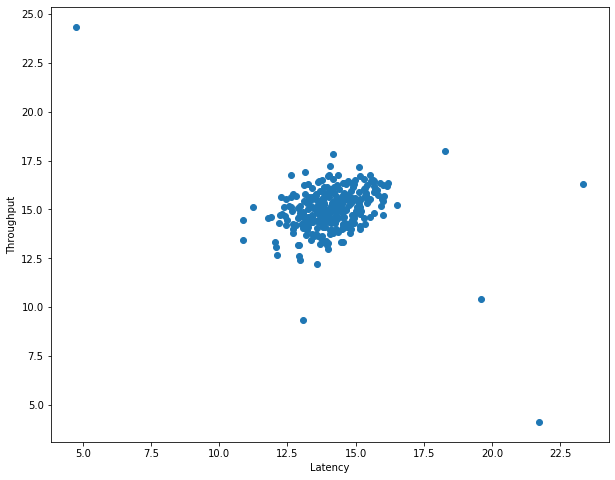

In [13]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,8))
plt.scatter(X[:, 0], X[:, 1])
plt.xlabel("Latency")
plt.ylabel("Throughput")

# Esitmating $\mu$ and $\sigma^2$
$$
\mu_i = \frac {1} {m} \sum_{j=1}^{m} x_{i}^{(j)}
$$
$$
\sigma_{i}^{2}=\frac{1}{m} \sum_{j=1}^{m}\left(x_{i}^{(j)}-\mu_{i}\right)^{2}
$$

In [34]:
mu = X.mean(axis=0)
var = X.var(axis=0) 

# same variance
# X_nor = X - mu
# var = np.power(X_nor, 2).mean(axis=0)

mu, var

(array([14.11222578, 14.99771051]), array([1.83263141, 1.70974533]))

# Calculating possiblities
Calculating possiblities of each feature of each sample. Assum that each feature statisies normal distribution.
$$
p\left(x_j^{(i)}, \mu_j, \sigma_j^{2}\right)=\frac{1}{\sqrt{2 \pi} \sigma_j} \exp \left(-\frac{(x_j^{(i)}-\mu_j)^{2}}{2 \sigma_j^{2}}\right)
$$

In [50]:
from scipy import stats

# for all samples
p = np.zeros(X.shape)
p = stats.norm(mu, var).pdf(X)

# for cross validation set
p_cv = np.zeros(CV.shape)
p_cv = stats.norm(mu, var).pdf(CV)

p.shape, p_cv.shape

((307, 2), (307, 2))

# Learning threshold $\epsilon$ from CV
Recall the definitions of precisoin and recall:
$$
\begin{aligned}
p r e c &=\frac{t p}{t p+f p} \\
r e c &=\frac{t p}{t p+f n}
\end{aligned}
$$
And $F_1$ score is harmonic mean that is computed using precision and recall:
$$
F_{1}=\frac{2 \cdot p r e c \cdot r e c}{p r e c +r e c}
$$
We want a threshold $epsilon$ that makes $F_1$ as large as possible so as to optimize both precison and recall.

In [80]:
def select_thres(p_cv, y_CV, max_iters=1000):
    best_e = 0
    best_f1 = 0
    
    step = (p_cv.max() - p_cv.min()) / max_iters
    
    for e in np.arange(p_cv.min(), p_cv.max(), step):
        preds = p_cv < e # (m,n) boolean matrix
        
        tp = np.sum(np.logical_and(preds == True, y_CV == 1)).astype(float)
        fp = np.sum(np.logical_and(preds == True, y_CV == 0)).astype(float)
        fn = np.sum(np.logical_and(preds == False, y_CV == 1)).astype(float)
        
        prec = tp / (tp + fp) if tp + fp > 0 else 0
        rec = tp / (tp + fn) if tp + fp > 0 else 0
        f_1 = 2 * prec * rec / (prec + rec) if prec + rec > 0 else 0
        
        if f_1 > best_f1:
            best_f1 = f_1
            best_e = e
            
    return best_e, best_f1

In [81]:
e, f_1 = select_thres(p_cv, y_CV)
e, f_1

(0.009566706005956842, 0.7142857142857143)

# Apply $\epsilon$ to find outliers

Text(0, 0.5, 'Throughput')

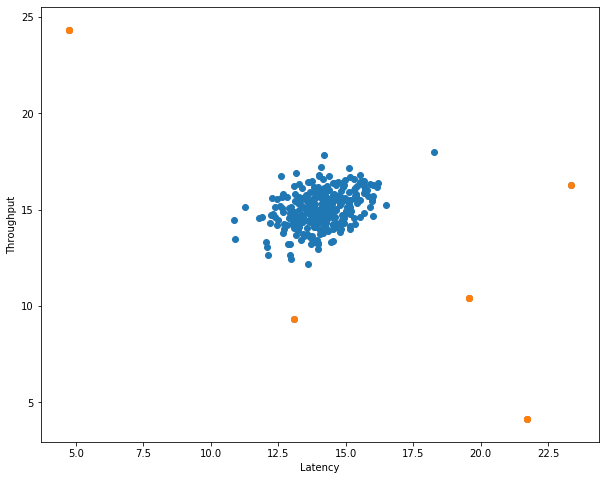

In [60]:
X_outliers = np.where(p < e) # indexs of the outliers

import matplotlib.pyplot as plt
plt.figure(figsize=(10,8))
plt.scatter(X[:, 0], X[:, 1])
plt.scatter(X[X_outliers[0], 0], X[X_outliers[0], 1])
plt.xlabel("Latency")
plt.ylabel("Throughput")